<a href="https://colab.research.google.com/github/njadux/Fashion-MNIST-VAE-with-Colorization/blob/main/Variational_Autoencoder_(VAE)_for_Fashion_MNIST_with_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST VAE with Colorization
This project contains a Variational Autoencoder (VAE) trained on the Fashion MNIST dataset. The model learns to encode grayscale fashion images into a lower-dimensional latent space and reconstruct them with optional colorization.

Features
- ✅ Train a VAE model on the Fashion MNIST dataset.
- ✅ Encode and decode fashion images using a learned latent space.
- ✅ Generate new fashion images from random latent vectors.
- ✅ Convert grayscale images to RGB using OpenCV colormaps.
- ✅ Visualize model outputs, including latent space traversal and colorized reconstructions.



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, ReLU, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') is not None and logs.get('loss') <= 100:
            print("\nLoss below 100, stopping training!")
            self.model.stop_training = True


callbacks = [LossCallback()]

In [6]:
# Load and preprocess Fashion MNIST dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
index = 4

# setting num of rows
np.set_printoptions(linewidth=320)

# print label
print(f'LABEL: {training_labels[index]}')
# print image
print(f'\nIMAGE PIXEL ARRAY:\n {training_images[index]}')

LABEL: 0

IMAGE PIXEL ARRAY:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 189 206 187  32   0   0   0  26 217 226 196  11   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 192 227 234 243 230 147 239 242 234 218 209   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 173 225 215 233 254   0 194 240 217 221 190   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 139 229 212 226 255   0 162 255 213 226 200   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  98 232 211 215 249  46 162 246 214 230 186   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  70 228 213 220 224 252 239 219 217 231 171   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  45 222 214 218 216 210 215 217 202 224 172   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  24 254 214 210 

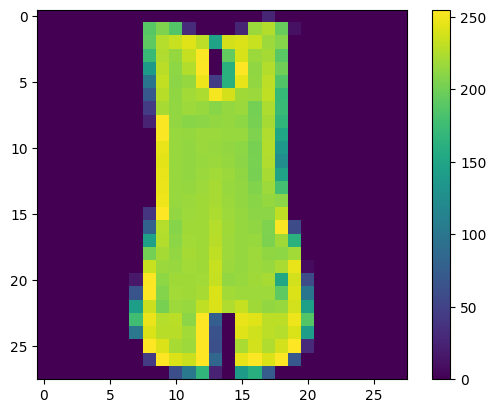

In [8]:
# visualize it using colormap
plt.imshow(training_images[index])
plt.colorbar()
plt.show()

In [9]:
training_images = training_images / 255.0
test_images = test_images / 255.0

In [10]:
training_images = np.expand_dims(training_images, axis=-1).astype("float32") #x_train is the original dataset.
# Convert training_images to a TensorFlow tensor
training_images = tf.convert_to_tensor(training_images)
training_images = tf.image.grayscale_to_rgb(training_images)

test_images = np.expand_dims(test_images, axis=-1).astype("float32")
test_images = np.tile(test_images, (1, 1, 1, 3)) # Convert grayscale to RGB

In [12]:
# Create TensorFlow datasets
batch_size = 32
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(training_images).shuffle(BUFFER_SIZE).batch(batch_size)

- Variational Autoencoders (VAEs) aim to learn a compressed representation (latent space) of your data.

> Think of it like learning a set of "codes" that can describe your data.


- This latent space is modeled as a probability distribution, often a Gaussian (normal) distribution.

In VAEs, we want to sample from a latent distribution, but directly sampling from
 >  z ~ N(z_mean, exp(z_log_var)) would make backpropagation impossible.

 The reparameterization trick allows gradients to flow through the network by expressing the sampling operation in a differentiable way.

In [13]:
# VAE Components
latent_dim = 100

VAE Model

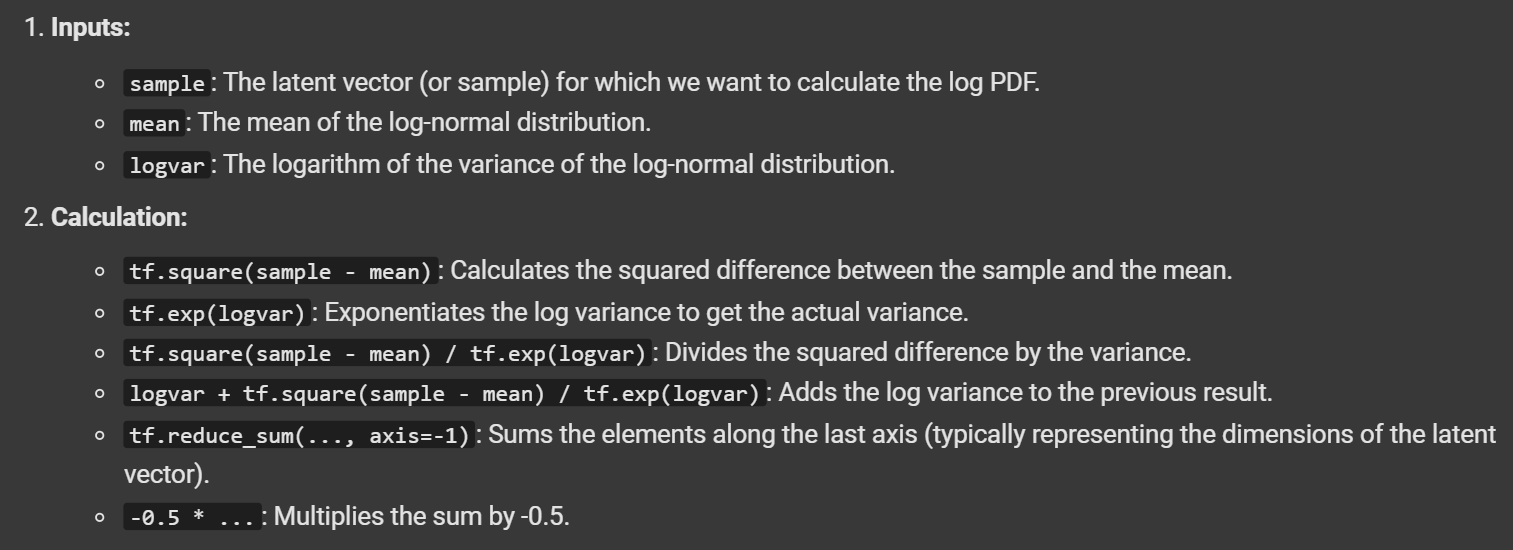

In [19]:
# Gaussian log probability function
def log_normal_pdf(sample, mean, logvar):
    return -0.5 * tf.reduce_sum(logvar + tf.square(sample - mean) / tf.exp(logvar), axis=-1)

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 3)),  # Adjust for dataset
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(2 * latent_dim)  # Output mean & logvar
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(7 * 7 * 64, activation="relu"),      # flattened feature vector.
            layers.Reshape((7, 7, 64)),      # Reshape to 7x7 feature map  3D
            layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(3, 3, strides=1, activation="sigmoid", padding="same")  # Sigmoid for pixel values
        ])

    def encode(self, x):
        x_encoded = self.encoder(x)
        mean, logvar = tf.split(x_encoded, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * logvar) * eps

    def decode(self, z):
        return self.decoder(z)

In [20]:
# Training Step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_recon = model.decode(z)

        # Compute BCE loss
        bce_loss = tf.keras.losses.binary_crossentropy(x, x_recon)
        bce_loss = tf.reduce_mean(bce_loss)

        # KL Divergence
        kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

        # Total Loss
        loss = bce_loss + kl_loss

        # Accuracy Calculation (add this)
        accuracy = tf.keras.metrics.binary_accuracy(x, x_recon) # Assuming binary images
        accuracy = tf.reduce_mean(accuracy) # Average across batch

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

In [21]:
# Initialize and train
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
# Ensure 'training_images' and 'test_images' have the correct shapes
training_images = tf.squeeze(training_images, axis=None)  # Remove unnecessary dimensions
test_images = tf.squeeze(test_images, axis=None)  # Remove unnecessary dimensions

# Check the shapes
print(training_images.shape)
print(test_images.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [23]:
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    total_accuracy = 0
    for step, x_batch in enumerate(train_dataset):
        loss, accuracy = train_step(vae, x_batch, optimizer) # Get accuracy
        total_loss += loss.numpy()
        total_accuracy += accuracy.numpy() # Accumulate accuracy

    print(f"Epoch {epoch+1}, Loss: {total_loss / (step+1):.4f}, Accuracy: {total_accuracy / (step+1):.4f}") # Print accuracy

Epoch 1, Loss: 0.4244, Accuracy: 0.4933
Epoch 2, Loss: 0.3892, Accuracy: 0.4973
Epoch 3, Loss: 0.3811, Accuracy: 0.4985
Epoch 4, Loss: 0.3779, Accuracy: 0.4990
Epoch 5, Loss: 0.3762, Accuracy: 0.4995
Epoch 6, Loss: 0.3750, Accuracy: 0.4997
Epoch 7, Loss: 0.3741, Accuracy: 0.5000
Epoch 8, Loss: 0.3736, Accuracy: 0.5001
Epoch 9, Loss: 0.3730, Accuracy: 0.5002
Epoch 10, Loss: 0.3728, Accuracy: 0.5003
Epoch 11, Loss: 0.3722, Accuracy: 0.5003
Epoch 12, Loss: 0.3720, Accuracy: 0.5004
Epoch 13, Loss: 0.3716, Accuracy: 0.5005
Epoch 14, Loss: 0.3715, Accuracy: 0.5005
Epoch 15, Loss: 0.3713, Accuracy: 0.5006


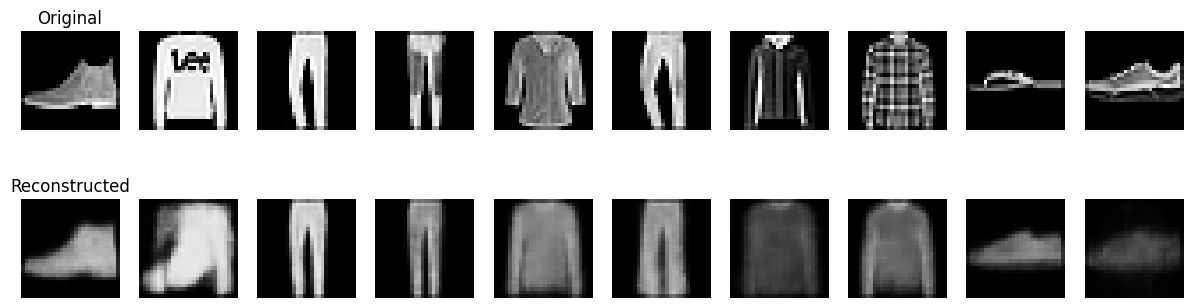

In [24]:
import matplotlib.pyplot as plt

# Select some test images
num_images = 10
test_samples = test_images[:num_images]  # Get first 10 test images

# Encode and Decode
mean, logvar = vae.encode(test_samples)
z = vae.reparameterize(mean, logvar)
reconstructed = vae.decode(z)

# Plot Original vs Reconstructed
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

for i in range(num_images):
    # Original
    axes[0, i].imshow(test_samples[i])
    axes[0, i].axis("off")

    # Reconstructed
    axes[1, i].imshow(reconstructed[i].numpy())
    axes[1, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.show()

# Define a Colorization Function

Generate and Colorize **Data**

In [28]:
import cv2
print(cv2.__version__)

4.11.0


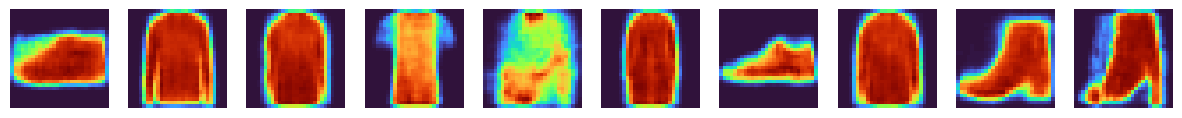

In [51]:
# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(10, latent_dim))

# Improved colorization function
def colorized(image, colormap=cv2.COLORMAP_TURBO):
    """ Applies colormap to a grayscale image with proper normalization. """

    # Ensure the image is in range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-5)

    # Convert to uint8 [0, 255] for OpenCV processing
    image_uint8 = (image * 255).astype(np.uint8)

    # Ensure single-channel grayscale
    if len(image_uint8.shape) == 3 and image_uint8.shape[-1] > 1:
        image_uint8 = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    elif len(image_uint8.shape) == 1:
        image_uint8 = np.expand_dims(image_uint8, axis=0)  # Make it 2D (HxW)

    # Apply colormap
    color_img = cv2.applyColorMap(image_uint8, colormap)

    # Convert BGR to RGB for Matplotlib display
    color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    return color_img

# Decode images using your trained VAE model
generated_images = vae.decode(random_latent_vectors)

# Plot generated images
fig, axes = plt.subplots(1, 10, figsize=(15, 4))

for i in range(10):
    img = generated_images[i].numpy()

    # Ensure grayscale image
    img = np.squeeze(img)

    # Apply improved color mapping
    img_colored = colorized(img, colormap=cv2.COLORMAP_TURBO)

    axes[i].imshow(img_colored)
    axes[i].axis("off")  # Hide axes for a cleaner look

plt.show()


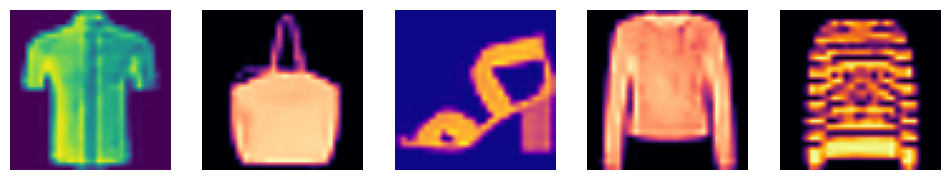

In [107]:
import random
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import FashionMNIST

# Define available colormaps
COLORMAPS = [
    cv2.COLORMAP_JET, cv2.COLORMAP_VIRIDIS, cv2.COLORMAP_INFERNO,
    cv2.COLORMAP_PLASMA, cv2.COLORMAP_MAGMA, cv2.COLORMAP_RAINBOW
]

# Function to apply colorization
def colorize_img(img, colormap=cv2.COLORMAP_JET):
    img_np = np.array(img)
    if img_np.dtype != np.uint8:
        img_np = (img_np * 255).astype(np.uint8)  # Normalize if necessary
    colored = cv2.applyColorMap(img_np, colormap)  # Apply chosen colormap
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return Image.fromarray(colored)

# Function to apply a random colormap
def colorize_img_random(img):
    colormap = random.choice(COLORMAPS)  # Pick a random colormap
    return colorize_img(img, colormap)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to 64x64
    transforms.Lambda(colorize_img_random),  # Apply a random color each time
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Load Dataset with Transform
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Display Some Images
import matplotlib.pyplot as plt

def show_batch(loader):
    images, _ = next(iter(loader))
    images = images.permute(0, 2, 3, 1).numpy()  # Convert from (C, H, W) to (H, W, C)

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

# Show a batch of colorized images
show_batch(train_loader)

Enter the number of images to generate: 6


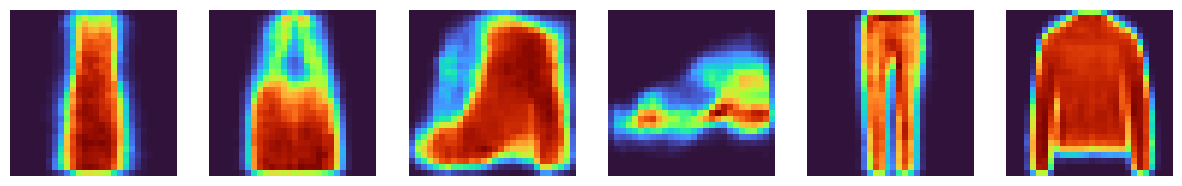

In [124]:
# letting user choose number of generated images
def generate_and_display_images(num_images, latent_dim=latent_dim, vae_model=vae):
    """
    Generates and displays a specified number of images using the trained VAE model.

    Args:
        num_images: The number of images to generate.
        latent_dim: The dimensionality of the latent space (default: latent_dim from your VAE).
        vae_model: The trained VAE model (default: vae from your code).
    """
    # Generate random latent vectors
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

    # Decode images using your trained VAE model
    generated_images = vae_model.decode(random_latent_vectors)

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))

    for i in range(num_images):
        img = generated_images[i].numpy()

        # Ensure grayscale image
        img = np.squeeze(img)

        # Apply improved color mapping
        img_colored = colorized(img, colormap=cv2.COLORMAP_TURBO)

        axes[i].imshow(img_colored)
        axes[i].axis("off")  # Hide axes for a cleaner look

    plt.show()

# Get user input for the number of images to generate
num_images_to_generate = int(input("Enter the number of images to generate: "))

# Generate and display the images
generate_and_display_images(num_images_to_generate)